In [1]:
import torch
# Some mode APIs are changing on master while this runs on colab
print(torch.__version__)
if not torch.__version__.split("+")[0] == "1.12.1":
    raise RuntimeError("This notebook is for pytorch 1.12")

1.12.1+cu113


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from collections import defaultdict
from typing import Dict
from contextlib import contextmanager

from torch.utils._python_dispatch import TorchDispatchMode

# We do want to use non-full hooks here as they behavior similar to
# backward pre-hooks
import warnings
warnings.filterwarnings("ignore", "Using a non-full backward")

MB = 1024 * 1024.0

# Globals used to save state
operator_names: Dict[str, int] = defaultdict(int)
mem_usage: Dict[str, float] = defaultdict(float)
max_mem_usage: Dict[str, float] = defaultdict(float)
markers: Dict[str, int] = defaultdict(int)
cur_module: str = ""
op_id: int = 0

def clear_state():
    operator_names.clear()
    mem_usage.clear()
    max_mem_usage.clear()
    markers.clear()


# To add markers in the final print
def add_marker(marker_name):
    marker_val = len(mem_usage.values())
    markers[marker_name] = marker_val

def record_fn(fn_name):
    global op_id
    mem: float = torch.cuda.memory_allocated() / MB
    mem_usage[op_id] = (fn_name, mem)
    max_mem: float = torch.cuda.max_memory_allocated() / MB
    max_mem_usage[op_id] = (fn_name, max_mem)
    torch.cuda.reset_peak_memory_stats()
    op_id += 1

# Mode that records all allocations
class MemoryProfileDispatchMode(TorchDispatchMode):
    def __torch_dispatch__(self, func, types, args=..., kwargs=None):
        rs = func(*args, **kwargs)
        global cur_module
        if func == torch.ops.aten.detach.default:
            return rs
        func_name: str = cur_module + '.' + func.__name__ + "_" + str(operator_names[func.__name__])
        operator_names[func.__name__] = operator_names[func.__name__] + 1
        record_fn(func_name)

        return rs

# Functions to print and draw the graph
def show_graph():
    import matplotlib.pyplot as plt

    y = [gb for (name, gb) in mem_usage.values()]
    min_val = min(y)
    max_val = max(y)
    x = [i for i in range(len(y))]
    fig = plt.figure(figsize=(16,8))
    plt.plot(x, list(y), label="memory")
    plt.xlabel("# Operator Calls")
    plt.ylabel("Allocated Memory (MB)")
    # plt.title(filename)
    for marker_name, marker in markers.items():
        if marker_name == "fw_bw_boundary":
            plt.plot([marker, marker], [min_val, max_val], "r", lw=2, label=marker_name)
        else:
            plt.plot([marker, marker], [min_val, max_val], "k-", lw=2, label=marker_name)
    plt.legend()

def print_top_mem_op(top: int = 50):
    global op_id
    op_diff: Dict[str, float] = defaultdict(float)
    op, pre_mem = mem_usage[0]
    for i in range(1, op_id):
        op, mem = mem_usage[i]
        op_diff[op] = mem - pre_mem
        pre_mem = mem

    print("------------------------------------------------")
    print(f"Top {top} ops that generates memory are:")
    for k, v in sorted(op_diff.items(), key=lambda item: item[1], reverse=True)[:top]:
        print(f"{k}: {v}MB")
    print("------------------------------------------------")


# Module level printing and logging to make the Mode's output better
def mem_profile_model(mod: torch.nn.Module, *args):
    with torch.utils._python_dispatch.push_torch_dispatch_mode(MemoryProfileDispatchMode):
        torch.cuda.reset_peak_memory_stats()
        mod.zero_grad(True)
        clear_state()
        record_fn("Start")
        loss = mod(*args)
        add_marker("fw_bw_boundary")
        if isinstance(loss, dict):
            loss = loss['out']
        loss.sum().backward()
        add_marker("bw_zero_boundary")
        mod.zero_grad(set_to_none=True)
        record_fn("Finished")

def fwd_wrapped(name): 
    def fwd_debug_hook(module, input) -> None:
        global cur_module
        cur_module = f"{name}.forward"
    return fwd_debug_hook

def bwd_wrapped(name):
    def bwd_debug_hook(module, input, out) -> None:
        global cur_module
        cur_module = f"{name}.backward"
    return bwd_debug_hook

# this context manager attached/detecheds hooks for debugging
@contextmanager
def debug_model(model):
    global op_id, cur_module
    hooks = []
    cur_module = 'forward'
    op_id = 0
    for name, module in model.named_modules():
        hooks.append(module.register_forward_pre_hook(fwd_wrapped(name)))
        hooks.append(module.register_backward_hook(bwd_wrapped(name)))
    try:
        yield model
    finally:
        for hook in hooks:
            hook.remove()

In [3]:
def run_one_model(net, input):
    net.cuda()
    input = input.cuda()

    with debug_model(net) as m:
        # mem_profile_model(m, input1, input2)
        mem_profile_model(m, input)
    print_top_mem_op(20)

    show_graph()

------------------------------------------------
Top 20 ops that generates memory are:
bn1.forward.cudnn_batch_norm.default_0: 98.0009765625MB
conv1.forward.convolution.default_0: 98.0MB
maxpool.forward.max_pool2d_with_indices.default_0: 74.5MB
layer1.0.conv1.backward.max_pool2d_with_indices_backward.default_0: 49.0MB
layer1.0.bn1.forward.cudnn_batch_norm.default_1: 24.5009765625MB
layer1.0.bn2.forward.cudnn_batch_norm.default_2: 24.5009765625MB
layer1.1.bn1.forward.cudnn_batch_norm.default_3: 24.5009765625MB
layer1.1.bn2.forward.cudnn_batch_norm.default_4: 24.5009765625MB
layer1.2.bn1.forward.cudnn_batch_norm.default_5: 24.5009765625MB
layer1.2.bn2.forward.cudnn_batch_norm.default_6: 24.5009765625MB
layer1.0.conv1.forward.convolution.default_1: 24.5MB
layer1.0.conv2.forward.convolution.default_2: 24.5MB
layer1.1.conv1.forward.convolution.default_3: 24.5MB
layer1.1.conv2.forward.convolution.default_4: 24.5MB
layer1.2.conv1.forward.convolution.default_5: 24.5MB
layer1.2.conv2.forward.co

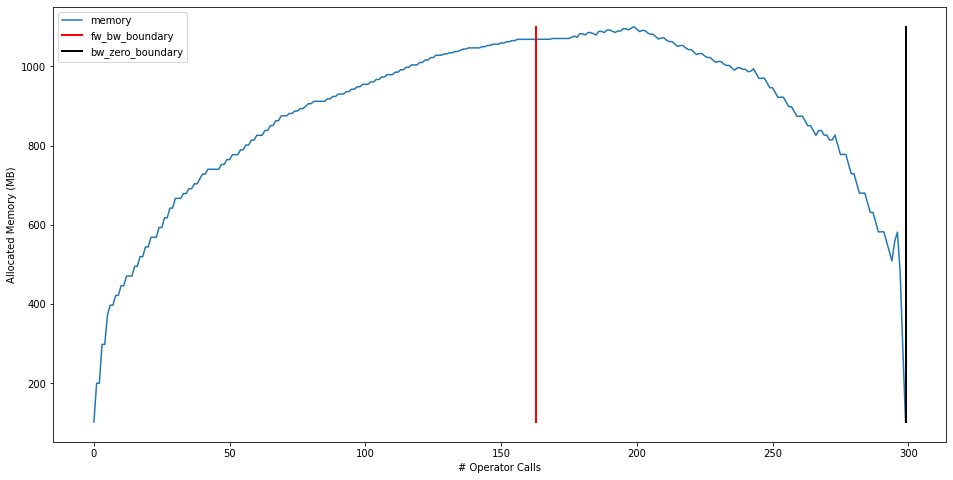

In [4]:
import torchvision
run_one_model(torchvision.models.resnet34(), torch.rand(32, 3, 224, 224, device="cuda"))

------------------------------------------------
Top 20 ops that generates memory are:
features.2.block.0.1.forward.cudnn_batch_norm.default_3: 98.0009765625MB
features.2.block.0.0.forward.convolution.default_3: 98.0MB
features.2.block.1.0.backward.threshold_backward.default_17: 73.5MB
features.2.block.1.1.backward.convolution_backward.default_57: 49.00146484375MB
features.3.block.0.1.forward.cudnn_batch_norm.default_6: 27.5634765625MB
features.3.block.1.1.forward.cudnn_batch_norm.default_7: 27.5634765625MB
features.4.block.0.1.forward.cudnn_batch_norm.default_9: 27.5634765625MB
features.3.block.0.0.forward.convolution.default_6: 27.5625MB
features.3.block.1.0.forward.convolution.default_7: 27.5625MB
features.4.block.0.0.forward.convolution.default_9: 27.5625MB
features.1.block.1.1.forward.cudnn_batch_norm.default_2: 25.5009765625MB
features.0.1.forward.cudnn_batch_norm.default_0: 24.5009765625MB
features.1.block.0.1.forward.cudnn_batch_norm.default_1: 24.5009765625MB
features.2.block.

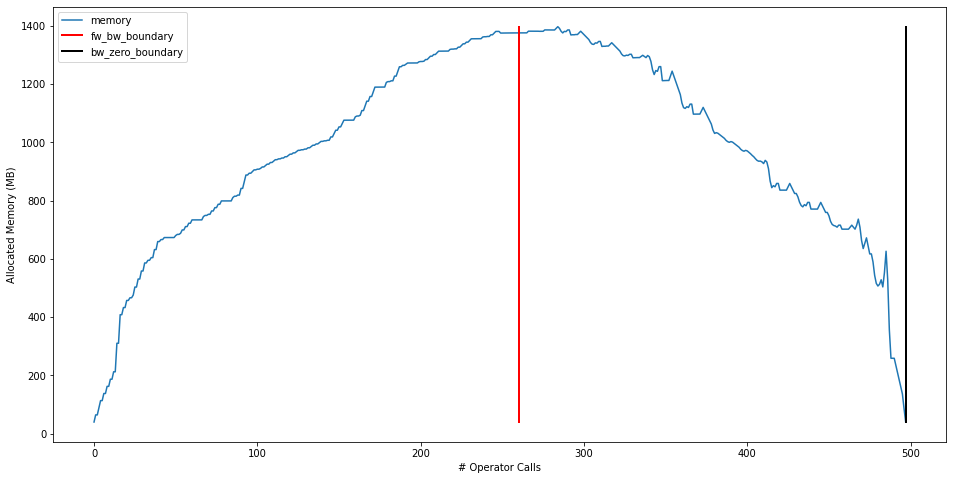

In [5]:
import torchvision
run_one_model(torchvision.models.mobilenet_v3_large(), torch.rand(32, 3, 224, 224, device="cuda"))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1018: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "


------------------------------------------------
Top 20 ops that generates memory are:
backbone.layer4.0.bn3.forward.cudnn_batch_norm.default_45: 196.015625MB
backbone.layer4.0.downsample.1.forward.cudnn_batch_norm.default_46: 196.015625MB
backbone.layer4.1.bn3.forward.cudnn_batch_norm.default_49: 196.015625MB
backbone.layer4.2.bn3.forward.cudnn_batch_norm.default_52: 196.015625MB
backbone.layer4.0.conv3.forward.convolution.default_45: 196.0MB
backbone.layer4.0.downsample.0.forward.convolution.default_46: 196.0MB
backbone.layer4.1.conv3.forward.convolution.default_49: 196.0MB
backbone.layer4.2.conv3.forward.convolution.default_52: 196.0MB
classifier.0.backward.threshold_backward.default_1: 147.0MB
backbone.layer4.2.conv1.backward.add.Tensor_0: 146.0MB
backbone.layer4.1.conv1.backward.add.Tensor_1: 146.0MB
classifier.1.backward.convolution_backward.default_1: 132.99609375MB
classifier.4.forward.upsample_bilinear2d.vec_0: 128.625MB
backbone.layer4.1.bn1.backward.convolution_backward.defa

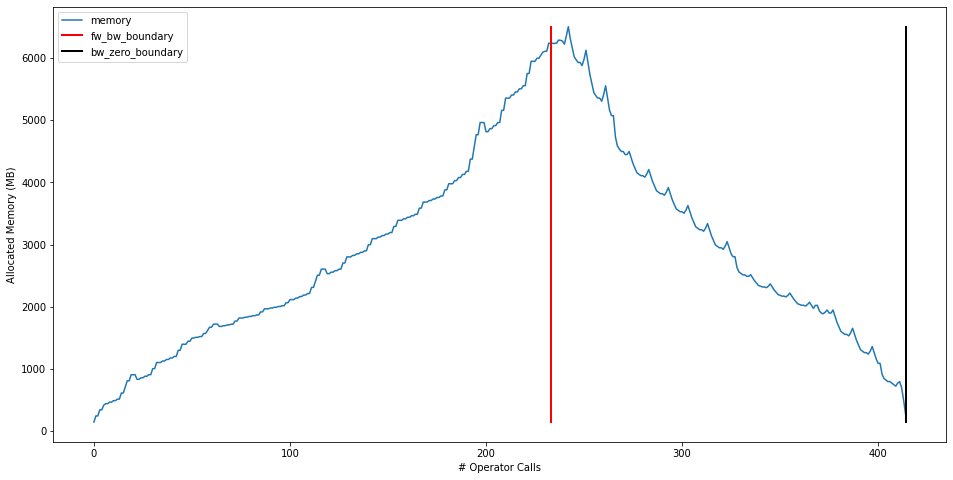

In [6]:
import torchvision
run_one_model(torchvision.models.segmentation.fcn_resnet50(), torch.rand(32, 3, 224, 224, device="cuda"))

------------------------------------------------
Top 20 ops that generates memory are:
encoder.layers.encoder_layer_0.mlp.0.forward.addmm.default_1: 18.75MB
encoder.layers.encoder_layer_0.mlp.1.forward.gelu.default_0: 18.75MB
encoder.layers.encoder_layer_1.mlp.0.forward.addmm.default_4: 18.75MB
encoder.layers.encoder_layer_1.mlp.1.forward.gelu.default_1: 18.75MB
encoder.layers.encoder_layer_2.mlp.0.forward.addmm.default_7: 18.75MB
encoder.layers.encoder_layer_2.mlp.1.forward.gelu.default_2: 18.75MB
encoder.layers.encoder_layer_3.mlp.0.forward.addmm.default_10: 18.75MB
encoder.layers.encoder_layer_3.mlp.1.forward.gelu.default_3: 18.75MB
encoder.layers.encoder_layer_4.mlp.0.forward.addmm.default_13: 18.75MB
encoder.layers.encoder_layer_4.mlp.1.forward.gelu.default_4: 18.75MB
encoder.layers.encoder_layer_5.mlp.0.forward.addmm.default_16: 18.75MB
encoder.layers.encoder_layer_5.mlp.1.forward.gelu.default_5: 18.75MB
encoder.layers.encoder_layer_6.mlp.0.forward.addmm.default_19: 18.75MB
encod

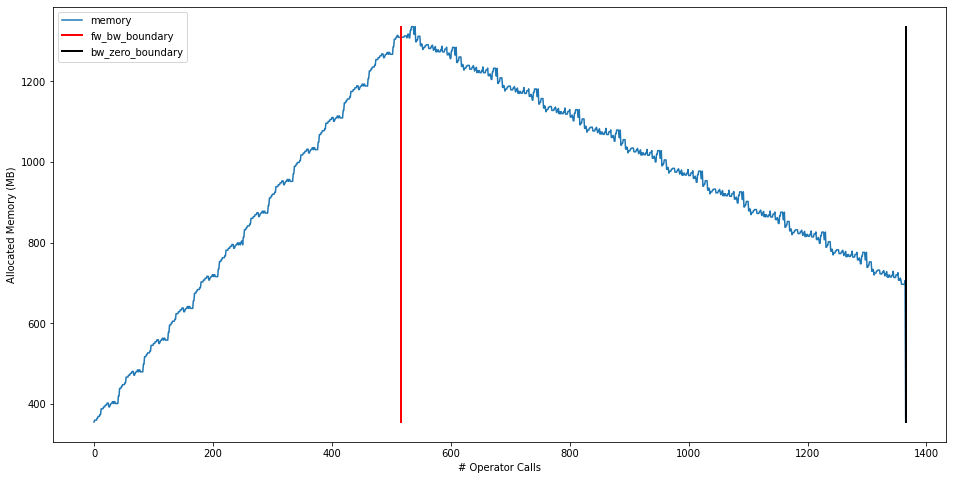

In [7]:
import torchvision
run_one_model(torchvision.models.vision_transformer.vit_b_32(), torch.rand(32, 3, 224, 224, device="cuda"))